# Imports

In [1]:
import sys
sys.path.append("..")
sys.path.append("../..")

import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.io import read_image
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
import json_tricks as json

from dataset_test import TestImageDataset
from dataset_train import TrainImageDataset

from utils.helper import load_config
from utils.transforms import gt_to_anchorpts
import configs.variables as variables

from helper.transforms import get_affine_transform

from helper.visuals import (showframe, showjoints, 
    showbbox, showlines, visualize, plot_by_joint, annotate_plot, set_title, show, show_grid, set_axis_style)

from helper.predict import (
    adjust_configs, most_recent_checkpoint, sort_checkpoints, load_checkpoint, get_pose, predict_joints, 
    predict, reorder_anchors)

from helper.deepdive import (getBool, get_arms_out, get_arms_down, getStats, compare_models, plot_by_joint_dist)

plt.rcParams["savefig.bbox"] = "tight"
device = torch.device('cuda:0')

# Constants

In [2]:
NUM_JOINTS = 15

ROOT_DIR = variables.ROOT_DIR
VOL_DIR = variables.VOL_DIR
CODE_DIR = variables.CODE_DIR
CHECKPOINTS_PREFIX = VOL_DIR + "checkpoints_"
PREPROCESSED_TO_ORIG = variables.PREPROCESSED_TO_ORIG # contains the file path of original frame as well
CONFIGS_DIR = variables.CONFIGS_DIR

TEST_SUBJECTS = ['S9', 'S11']
NORMALIZE = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

SCALE_FACTOR = 170

METRIC = 0.05

DISTS_DIR = variables.DISTS_DIR
VAR_DIR = variables.VAR_DIR

#COLORS = ["#%06x" % x for x in np.linspace(0, 0xFFFFFF, NUM_JOINTS, dtype=int)]

DPI = 300

# Load models and configs, MORE CONSTANTS

In [3]:
from models.model_mse_twostepwarp import Model as model1
from models.model_mse import Model as model2

POSTFIX1 = "mse_natural_flipaugment_twostepwarp"
POSTFIX2 = "mse_natural"

MODEL1 = "+ MSE loss | Natural pose | Two-step warp | Flip augment"
MODEL2 = "+ MSE loss | Natural pose"

CONFIG1_YAML = POSTFIX1 + ".yaml"
CONFIG2_YAML = POSTFIX2 + ".yaml"

CHECKPOINTS_FOLDER1 = CHECKPOINTS_PREFIX + POSTFIX1 + "/"
CHECKPOINTS_FOLDER2 = CHECKPOINTS_PREFIX + POSTFIX2 + "/"

LABELS = np.array(['abdomen', 
          'hipR', 'kneeR', 'ankleR', 
          'hipL', 'kneeL', 'ankleL',
          'chest', 'neck',
          'shoulderR', 'elbowR', 'wristR',
          'shoulderL', 'elbowL', 'wristL'])

SORTED_INDICES = np.array([7, 0, 8,
                        1, 4,
                        9, 12,
                        2, 5,
                        3, 6,
                        10, 13,
                        11, 14])

diamond_rotated = MarkerStyle('d')
diamond_rotated._transform.rotate_deg(90)
MARKERS = np.array(["o", 
           ">", "^", "h", 
           "<", "v", "H", 
           "*", "p", 
           "s", "X", "d",
           "D", "P", diamond_rotated])

POSE_GT = torch.load("pose_collection.pt") # DATASET_LENGTH, NUM_JOINTS, 2
DIAGONAL_GT = torch.load("diagonal_collection.pt") # DATASET_LENGTH

OUT_ANGLE = 20
DOWN_ANGLE = 45

#COLORS = ["#33cccc", "#ff5050", "#9900cc", "#009900", "#ff00ff", "#0080ff", "#333399", "#ff8000"]
COLORS = ["#33cccc", "#ff5050", "#9900cc", "#009900", "#ff00ff", "#0080ff", "#333399", "#ff8000",
            "#00ff00", "#ff00ff", "#ccccff", "#ffff00", "#ff6699", "#ccffcc", "#008080"]

# Quantitative Analysis

## 1.1 Overall

+ MSE loss | Natural pose | Two-step warp
	PDJ@0.05 1 Overall:  39.041351318359375
+ MSE loss | Natural pose | Two-step warp | Flip augment
	PDJ@0.05 2 Overall:  42.60821533203125
+ MSE loss | Natural pose | Two-step warp
	Normalize L2 1 Overall:  7.022559642791748
+ MSE loss | Natural pose | Two-step warp | Flip augment
	Normalize L2 2 Overall:  6.428316116333008


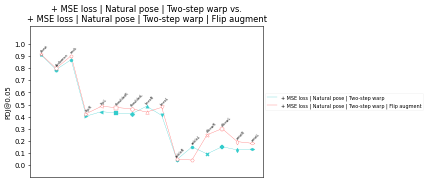

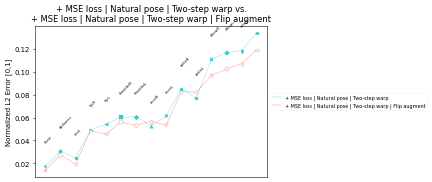

In [9]:
# load dists
dist1_collection = torch.load(DISTS_DIR + POSTFIX1 + ".pt") # DATASET_LENGTH, NUM_JOINTS
dist2_collection = torch.load(DISTS_DIR + POSTFIX2 + ".pt") # DATASET_LENGTH, NUM_JOINTS
compare_models(dist1_collection, dist2_collection, DIAGONAL_GT, 
               MODEL1, MODEL2, MARKERS, SORTED_INDICES, COLORS, LABELS, dpi=50)

## 1.2 Arm out

+ MSE loss | Natural pose | Two-step warp
	PDJ@0.05 1 Overall:  77.56090545654297
+ MSE loss | Natural pose | Two-step warp | Flip augment (arms out)
	PDJ@0.05 2 Overall:  77.61322021484375
+ MSE loss | Natural pose | Two-step warp
	Normalize L2 1 Overall:  3.247663736343384
+ MSE loss | Natural pose | Two-step warp | Flip augment (arms out)
	Normalize L2 2 Overall:  2.835195779800415


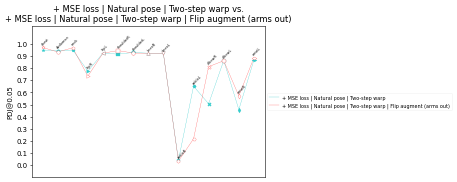

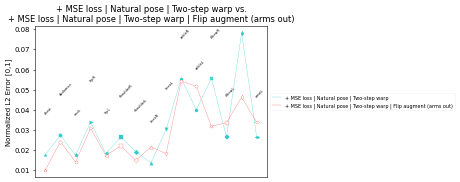

In [10]:
armsout_indices = get_arms_out(POSE_GT, 20)

ARMSOUT_POSE_GT = POSE_GT[armsout_indices,:,:]
ARMSOUT_DIAGONAL_GT = DIAGONAL_GT[armsout_indices]
armsout_dist1_collection = dist1_collection[armsout_indices, :]
armsout_dist2_collection = dist2_collection[armsout_indices, :]

compare_models(armsout_dist1_collection, armsout_dist2_collection, ARMSOUT_DIAGONAL_GT, 
               MODEL1, MODEL2 + " (arms out)", MARKERS, SORTED_INDICES, COLORS, LABELS, dpi=50)

## 1.3 Arms down

+ MSE loss | Natural pose | Two-step warp
	PDJ@0.05 1 Overall:  37.894187927246094
+ MSE loss | Natural pose | Two-step warp | Flip augment (arms down)
	PDJ@0.05 2 Overall:  42.363243103027344
+ MSE loss | Natural pose | Two-step warp
	Normalize L2 1 Overall:  7.075758934020996
+ MSE loss | Natural pose | Two-step warp | Flip augment (arms down)
	Normalize L2 2 Overall:  6.339773654937744


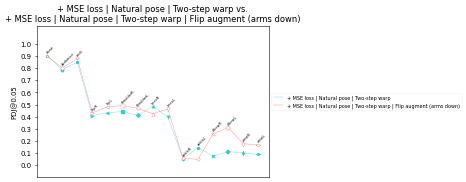

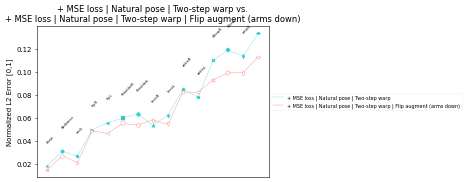

In [11]:
armsdown_indices = get_arms_down(POSE_GT, DOWN_ANGLE)

ARMSDOWN_POSE_GT = POSE_GT[armsdown_indices,:,:]
ARMSDOWN_DIAGONAL_GT = DIAGONAL_GT[armsdown_indices]
armsdown_dist1_collection = dist1_collection[armsdown_indices, :]
armsdown_dist2_collection = dist2_collection[armsdown_indices, :]

compare_models(armsdown_dist1_collection, armsdown_dist2_collection, ARMSDOWN_DIAGONAL_GT, 
               MODEL1, MODEL2 + " (arms down)", MARKERS, SORTED_INDICES, COLORS, LABELS, dpi=50)

### All, arms out, arms down

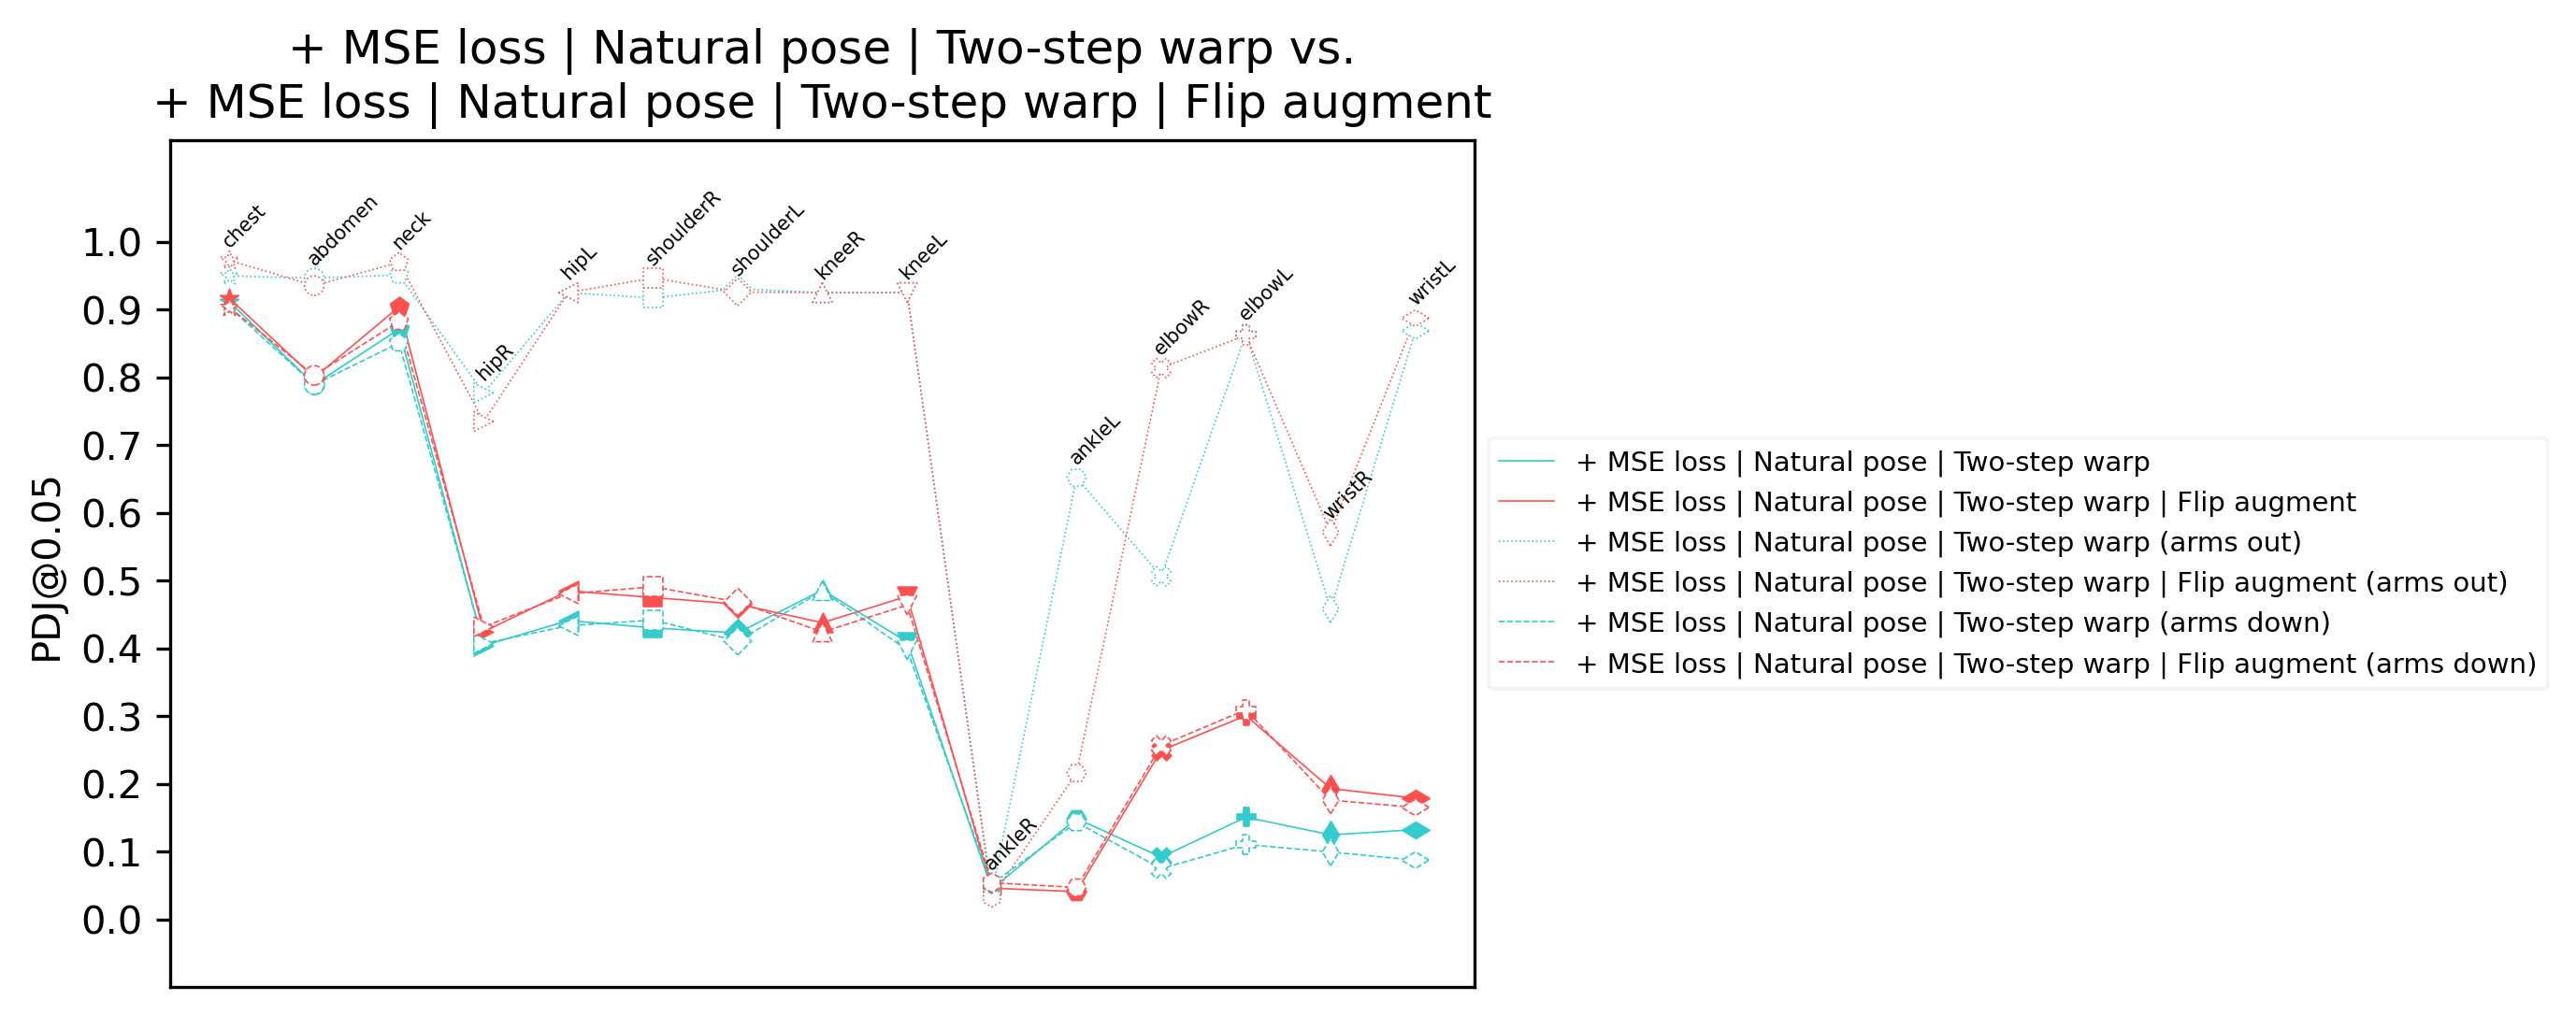

In [12]:
fig, ax = plt.subplots(dpi = DPI)

ylabel = "PDJ@0.05"
pdj_by_joint1 = plot_by_joint_dist(ax, dist1_collection, DIAGONAL_GT, 
                   MODEL1, MARKERS, SORTED_INDICES, COLORS[0], ylabel=ylabel)
pdj_by_joint2 = plot_by_joint_dist(ax, dist2_collection, DIAGONAL_GT, 
                   MODEL2, MARKERS, SORTED_INDICES, COLORS[1], ylabel=ylabel)

armsout_pdj_by_joint1 = plot_by_joint_dist(ax, armsout_dist1_collection, ARMSOUT_DIAGONAL_GT, 
                   MODEL1 + " (arms out)", MARKERS, SORTED_INDICES, COLORS[0], empty=True, linestyle=":", ylabel=ylabel)
armsout_pdj_by_joint2 = plot_by_joint_dist(ax, armsout_dist2_collection, ARMSOUT_DIAGONAL_GT, 
                   MODEL2 + " (arms out)", MARKERS, SORTED_INDICES, COLORS[1], empty=True, linestyle=":", ylabel=ylabel)

armsdown_pdj_by_joint1 = plot_by_joint_dist(ax, armsdown_dist1_collection, ARMSDOWN_DIAGONAL_GT, 
                   MODEL1 + " (arms down)", MARKERS, SORTED_INDICES, COLORS[0], empty=True, linestyle="--", ylabel=ylabel)
armsdown_pdj_by_joint2 = plot_by_joint_dist(ax, armsdown_dist2_collection, ARMSDOWN_DIAGONAL_GT, 
                   MODEL2 + " (arms down)", MARKERS, SORTED_INDICES, COLORS[1], empty=True, linestyle="--", ylabel=ylabel)

set_title(ax, MODEL1 + " vs.\n" + MODEL2)

stacked = torch.stack([pdj_by_joint1, pdj_by_joint2, 
                       armsout_pdj_by_joint1, armsout_pdj_by_joint2, 
                       armsdown_pdj_by_joint1, armsdown_pdj_by_joint2])
annotate_plot(ax, stacked, LABELS, SORTED_INDICES)


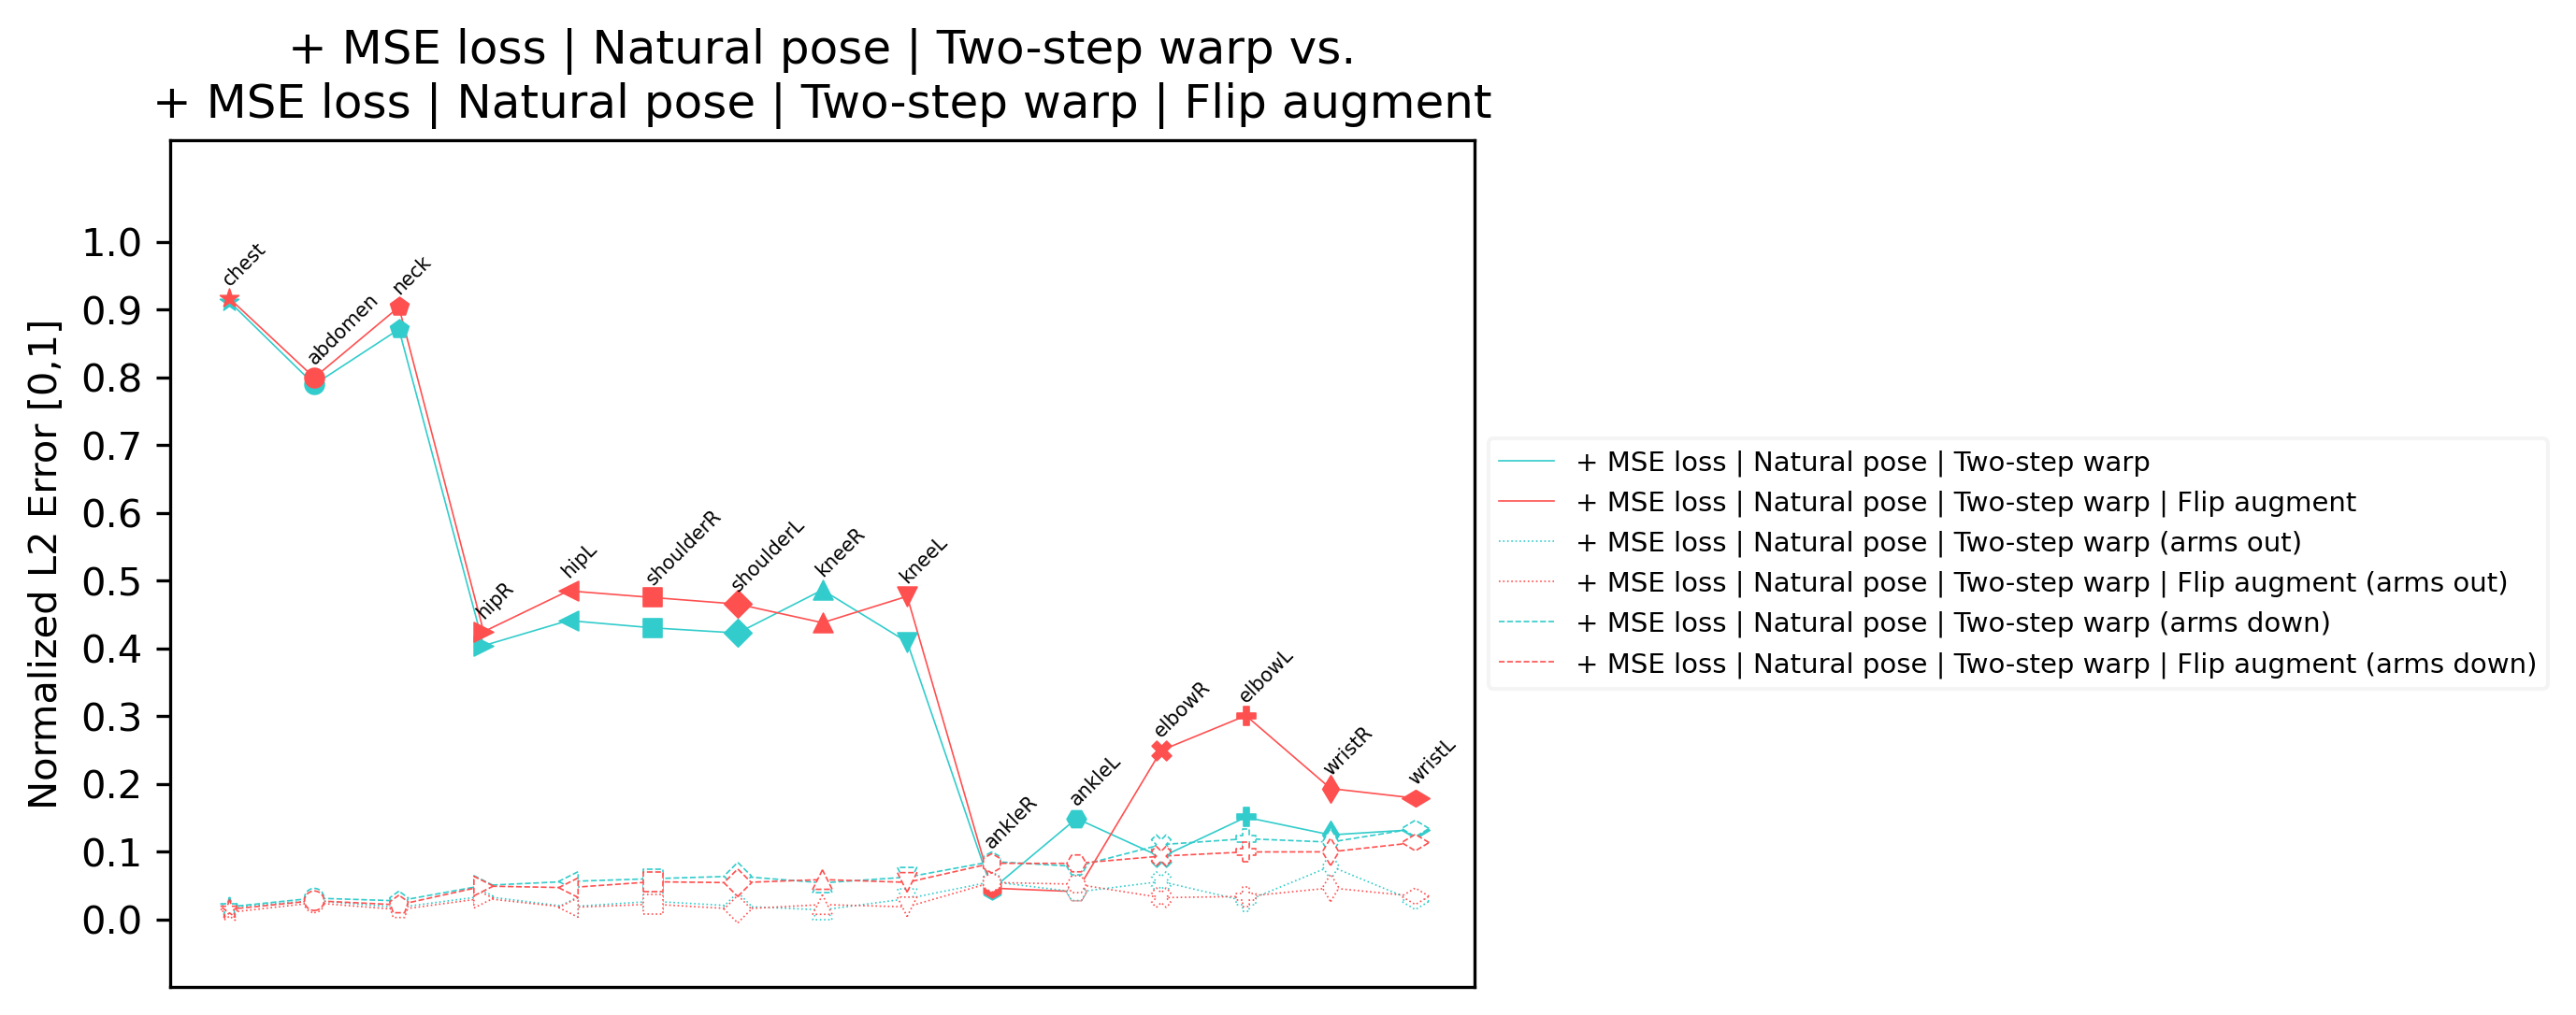

In [13]:
fig, ax = plt.subplots(dpi = DPI)

ylabel = "Normalized L2 Error [0,1]"
usePDJ = False

error_by_joint1 = plot_by_joint_dist(ax, dist1_collection, DIAGONAL_GT, 
                   MODEL1, MARKERS, SORTED_INDICES, COLORS[0], ylabel=ylabel)
error_by_joint2 = plot_by_joint_dist(ax, dist2_collection, DIAGONAL_GT, 
                   MODEL2, MARKERS, SORTED_INDICES, COLORS[1], ylabel=ylabel)

armsout_error_by_joint1 = plot_by_joint_dist(ax, armsout_dist1_collection, ARMSOUT_DIAGONAL_GT, 
                   MODEL1 + " (arms out)", MARKERS, SORTED_INDICES, COLORS[0], 
                                           empty=True, linestyle=":", ylabel=ylabel, usePDJ=usePDJ)
armsout_error_by_joint2 = plot_by_joint_dist(ax, armsout_dist2_collection, ARMSOUT_DIAGONAL_GT, 
                   MODEL2 + " (arms out)", MARKERS, SORTED_INDICES, COLORS[1], 
                                           empty=True, linestyle=":", ylabel=ylabel, usePDJ=usePDJ)

armsdown_error_by_joint1 = plot_by_joint_dist(ax, armsdown_dist1_collection, ARMSDOWN_DIAGONAL_GT, 
                   MODEL1 + " (arms down)", MARKERS, SORTED_INDICES, COLORS[0], 
                                            empty=True, linestyle="--", ylabel=ylabel, usePDJ=usePDJ)
armsdown_error_by_joint2 = plot_by_joint_dist(ax, armsdown_dist2_collection, ARMSDOWN_DIAGONAL_GT, 
                   MODEL2 + " (arms down)", MARKERS, SORTED_INDICES, COLORS[1], 
                                            empty=True, linestyle="--", ylabel=ylabel, usePDJ=usePDJ)

set_title(ax, MODEL1 + " vs.\n" + MODEL2)

stacked = torch.stack([error_by_joint1, error_by_joint2, 
                       armsout_error_by_joint1, armsout_error_by_joint2, 
                       armsdown_error_by_joint1, armsdown_error_by_joint2])
annotate_plot(ax, stacked, LABELS, SORTED_INDICES)

# Dataset distribution analysis

In [51]:
# Number of arms down/arms out
print("# of arms out: ", torch.sum(armsout_indices))
print("# of arms down: ", torch.sum(armsdown_indices))

# of arms out:  tensor(2039, device='cuda:0')
# of arms down:  tensor(80178, device='cuda:0')


In [52]:
# POSE_GT.shape torch.Size([dataset size, 15, 2])
stdevs = torch.std(POSE_GT, dim=0) 
right_pose_gt = POSE_GT[:,[1,3,10,11]]
left_pose_gt = POSE_GT[:,[4,6,13,14]]

In [53]:
torch.std(right_pose_gt, dim=0)

tensor([[20.4225, 14.3171],
        [22.3754, 16.3352],
        [28.4914, 17.4677],
        [27.2028, 23.7090]], device='cuda:0')

In [54]:
torch.std(left_pose_gt, dim=0)

tensor([[19.1961, 14.4471],
        [21.5505, 15.5401],
        [26.4815, 18.2748],
        [26.5179, 25.4397]], device='cuda:0')

## Multiple model comparison

In [10]:
POSTFIXS = ["pretrained", "baseline", "mse", "natural", "mse_natural", "mse_natural_flipaugment", 
            "mse_natural_flipaugment_twostepwarp", "mse_natural_twostepwarp",
            "mse_flipaugment_twostepwarp",
            "constrained"]
MODEL_NAMES = ["Schmidt et al.", "baseline", "MSE", "natural pose", "MSE + natural pose", "MSE + natural pose + flip augment", 
            "MSE + natural pose\n+ flip augment + two-step warp", "MSE + natural pose + two-step warp",
            "MSE + flip augment + two-step warp",
               "Constrained M"]
NUM_MODELS = len(POSTFIXS)

In [ ]:
# Bar graph with overall PDJ by model
fig, ax = plt.subplots(dpi = DPI)
fig.subplots_adjust(left=0.5)
fig.set_figwidth(11)
x_marks = np.array(list(range(NUM_MODELS)))
pdj_by_model = []
for p in range(len(POSTFIXS)):
    postfix = POSTFIXS[p]
    dist_collection = torch.load(DISTS_DIR + postfix + ".pt") # DATASET_LENGTH, NUM_JOINTS
    pdj_by_joint, pdj_by_frame, pdj_overall, error_by_joint, error_by_frame, error_overall = getStats(dist_collection, DIAGONAL_GT)
    pdj_by_model.append(pdj_by_frame.cpu().numpy())

pdj_by_model = np.array(pdj_by_model).T

vplots = ax.violinplot(pdj_by_model, vert=False, showmeans=False, showmedians=False, showextrema=False)
bplots = ax.boxplot(pdj_by_model, vert=False)

ax.set_xlabel("PDJ@0.05")
ax.set_title("PDJ@0.05 Distribution by Model")

# fill with colors
for i in range(NUM_MODELS):
    vplot = vplots['bodies'][i]
    vplot.set_facecolor(COLORS[i])
    #vplot.set_edgecolor('black')
    vplot.set_alpha(1)
    
set_axis_style(ax, MODEL_NAMES, fontsize=5)

for i in bplots:
    for patch in bplots[i]:
        patch.set_color("black")
        patch.set_linewidth(0.5)

show()

In [ ]:
# Bar graph with overall Normalized l2 error by model
fig, ax = plt.subplots(dpi = DPI)
fig.subplots_adjust(left=0.5)
fig.set_figwidth(11)
x_marks = np.array(list(range(NUM_MODELS)))
pdj_by_model = []
for p in range(len(POSTFIXS)):
    postfix = POSTFIXS[p]
    dist_collection = torch.load(DISTS_DIR + postfix + ".pt") # DATASET_LENGTH, NUM_JOINTS
    pdj_by_joint, pdj_by_frame, pdj_overall, error_by_joint, error_by_frame, error_overall = getStats(dist_collection, DIAGONAL_GT)
    error_by_frame = torch.log(error_by_frame) / torch.log(torch.tensor(10))
    pdj_by_model.append(error_by_frame.cpu().numpy())

pdj_by_model = np.array(pdj_by_model).T

vplots = ax.violinplot(pdj_by_model, vert=False, showmeans=False, showmedians=False, showextrema=False)
bplots = ax.boxplot(pdj_by_model, vert=False)

ax.set_xlabel("Normalized L2 Error (log scale)")
ax.set_title("Normalized L2 Error Distribution by Model (log scale)")

# fill with colors
for i in range(NUM_MODELS):
    vplot = vplots['bodies'][i]
    vplot.set_facecolor(COLORS[i])
    #vplot.set_edgecolor('black')
    vplot.set_alpha(1)
    
set_axis_style(ax, MODEL_NAMES, fontsize=5)

for i in bplots:
    for patch in bplots[i]:
        patch.set_color("black")
        patch.set_linewidth(0.5)

show()

# Body proportion variance

In [ ]:
var1_collection = torch.load(VAR_DIR + POSTFIX1 + ".pt") # DATASET_LENGTH, NUM_JOINTS
var2_collection = torch.load(VAR_DIR + POSTFIX2 + ".pt") # DATASET_LENGTH, NUM_JOINTS
var3_collection = torch.load(VAR_DIR + "baseline" + ".pt") # DATASET_LENGTH, NUM_JOINTS
var4_collection = torch.load(VAR_DIR + "pretrained" + ".pt") # DATASET_LENGTH, NUM_JOINTS

In [ ]:
torch.std(var1_collection, dim=0).shape

torch.Size([13])

In [ ]:
torch.mean(torch.std(var1_collection, dim=0)) # then take reciprocal

tensor(0.1935, device='cuda:0')

In [ ]:
torch.mean(torch.std(var2_collection, dim=0)) # then take reciprocal

tensor(0.0812, device='cuda:0')

In [ ]:
torch.mean(torch.std(var3_collection, dim=0)) # then take reciprocal

tensor(0.1018, device='cuda:0')

In [ ]:
torch.mean(torch.std(var4_collection, dim=0)) # then take reciprocal

tensor(0.4924, device='cuda:0')